# CH5. 실습 예제 확장하기

## 1) 새로운 애플리케이션 만들기

> **BOOKS 애플리케이션**   
> 책을 출판하는데 필요한 책, 저자, 출판사에 대한 정보들을 관리하는 웹 애플리케이션   
> 1. 애플리케이션 설계   
> 2. 프로젝트 뼈대 제작   
> 3. Model 코딩   
> 4. URLconf 코딩   
> 5. View 코딩   
> 6. Template 코딩   

*출판에 대한 정보를 보여주고 입력, 수정, 삭제할 수 있는 웹 애플리케이션*

## 페이지 설계   

> **1. index.html**   
> Book Mgmt System   
> Author   
> Publisher   

> **2. book_list.html**   
> Python Web Programming   
> Design Pattern   
> Effective Java   

> **3. book_detail.html**   
> Author : S.H.Kim   
> Publisher : HanBit   
> Publication date : March 1, 2015   

## 테이블 설계   

> **1. Books 테이블**   
> id (Integer, NotNull, PK, AutoIncrement)      
> title (varchar(100), NotNull)   
> authors (Integer, NotNull, MTM.index)   
> publisher (Integer, NotNull, FK.index)   
> publication_date (date, NotNull)   

> **2. Author 테이블**   
> id (Integer, NotNull, PK, AutoIncrement)   
> salutation (varchar(100), NotNull)   
> name (varchar(50), NotNull)   
> email (email, NotNull)   

> **3. Publisher 테이블**   
> id (Integer, NotNull, PK, AutoIncrement)   
> name (varchar(50), NotNull)   
> address (varchar(200), NotNull)   
> website (url, NotNull)

## 뷰 흐름 설계   

> **URL -> View -> Template**   
> /books/ -> BooksModelView.as_view() -> index.html   
> /books/book/ -> BookList.as_view() -> book_list.html   
> /books/book/3 -> BookDetail.as_view() -> book_detail.html

## 2) 프로젝트 뼈대 만들기 - 애플리케이션 추가   

**1. 프로젝트 생성**
```
django-admin startproject mysite
```

**2. 애플리케이션 추가**
```
python manage.py startapp books
```

**3. settings.py 수정**
```
INSTALLED_APPS = [
    'django.contrib.admin',
    'django.contrib.auth',
    'django.contrib.contenttypes',
    'django.contrib.sessions',
    'django.contrib.messages',
    'django.contrib.staticfiles',
    # 추가된 설정
    'books.apps.BooksConfig',
]

TIME_ZONE = 'Asia/Seoul'
```

**4. 계정 생성**
```
python manage.py createsuperuser

## 3) 애플리케이션 - Model 코딩하기

**1. 테이블 정의**   
```
books/models.py

from django.db import models

class Book(models.Model) :
    # id 자동 생성
    title = models.CharField(max_length = 100)
    authors = models.ManyToManyField('Author')
    publisher = models.ForeignKey('Publisher', on_delete = models.CASCADE)

    def __str__(self) :
        return self.title


class Author(models.Model) :
    # id 자동 생성
    salutation = models.CharField(max_length = 100)
    name = models.CharField(max_length = 50)
    email = models.EmailField()

    def __str__(self) :
        return self.name


class Publisher(models.Model) :
    # id 자동 생성
    name = models.CharField(max_length = 50)
    address = models.CharField(max_length = 200)
    website = models.URLField()

    def __str__(self) :
        return self.name
```

> **테이블 관계 설정**   
> 1. ManyToMany : Book - Author 관계를 N:N으로 설정 (한 책에 많은 저자, 한 저자에 많은 책)   
> 2. ForeignKey : Book - Publisher 관계를 N:1으로 설정 (여러 권의 책과 하나의 출판사)   
>    > **on_delete 옵션 필수 지정 - CASCADE : 삭제가 연관됨**   
> 3. OneToOneField : 1:1 관계

**2. 테이블 등록**   
```
books/admin.py

from django.contrib import admin
# 내가 만든 테이블 등록
from books.models import Book, Author, Publisher

admin.site.register(Book)
admin.site.register(Author)
admin.site.register(Publisher)
```

**3. 데이터베이스 변경**
```
python manage.py makemigrations   
python manage.py migrate   
```

**4. 서버 가동**   
```
python manage.py runserver 0:80000   
```

## 4) 애플리케이션 - URLconf 코딩하기

**1. mysite - url 설정**
```
mysite/urls.py

from django.contrib import admin
# include 추가
from django.urls import path, include

urlpatterns = [
    path('admin/', admin.site.urls),
    # path('polls/', include('polls.urls')),
    path('books/', include('books.urls')),
]
```

**2. books - url 설정**
```
books/urls.py

from django.urls import path
from . import views

app_name = 'books'

urlpatterns = [

    #path('이름', 사용할 함수, url 이름)
    
    # /books/
    path('', views.BooksModelView.as_view(), name = 'index'),

    #/books/book/
    path('book/', views.BookList.as_view(), name = 'book_list'),

    #/books/author/
    path('author/', views.AuthorList.as_view(), name = 'author_list'),

    #/books/publisher/
    path('publisher/', views.PublisherList.as_view(), name = 'publisher_list'),

    #/books/book/99/
    path('book/<int:pk>/', views.BookDetial.as_view(), name = 'book_detail'),

    #/books/author/99/
    path('author/<int:pk>', views.AuthorDetail.as_view(), name = 'author_detail'),

    #/books/publisher/99/
    path('publisher/<int:pk>', views.PublisherDetail.as_view(), name = 'publisher_detail'),
]
```

## 5) 애플리케이션 - 클래스형 View 코딩하기

: as_view()로 만든 클래스형 뷰 정의하기

```
books/views.py

# 제너릭 뷰 사용 정의
from django.views.generic.base import TemplateView
from django.views.generic import ListView
from django.views.generic import DetailView
# 테이블 사용 정의
from books.models import Book, Author, publisher

# TemplateView
# 템플릿 렌더링 제너릭 뷰
class BooksModelView(TemplateView) :
    # 클래스 변수 오버라이딩 저장 필수
    template_name = 'books/index.html'

    def get_context_data(self, **kwargs) :
        # 넘겨줄 변수를 메소드로 오버라이딩, super 필수
        context = super().get_context_data(**kwargs)
        # 테이블 리스트 보여주기
        context['model_list'] = ['Book', 'Author', 'Publisher']
        # return 필수
        return context

# ListView
class BookList(ListView) :
    # 가져올 객체 지정
    model = book
    # Book 테이블로부터 모든 레코드를 가져와 object_list 변수 구성 (자동)
    # books/book_list.html 템플릿 구성 (자동)

class AuthorList(ListView) :
    model = Author

class PublisherList(ListView) :
    model = Publisher

# DetailView
# 특정 객체 하나를 컨텍스트 변수에 담아서 템플릿 시스템에 넘겨줌
class BookDetail(DetailView) :
    # PK 값을 조회해서 쓰는 경우 테이블명만 지정
    model = Book
    # 컨텍스트 변수 object, 템플릿 파일 지정 (자동)
    # books/book_detail.html

class AuthorDetail(DetailView) :
    model = Author

class PublisherDetail(DetailView) :
    model = Publisher
```

## 6) 애플리케이션 - Template 코딩하기

**1. 템플릿 파일 생성**
```
mkdir template
mkdir template\books
```

**2. html 생성**
```
<!-- index.html -->
<!-- base_books.html 상속받기 -->
{% extends "base_books.html" %}

{% block content %}
    <h2> Books Management System </h2>
    <ul>
        {% for modelname in model_list %}
<!-- urlvar : URL 추출 -->
<!-- "books:모델 이름 더하기|소문자 변경|_list 붙이기", "books:author_list" -->
{% with "books:"|add:modelname|lower|add:"_list" as urlvar %}
            <li><a href = "{% url urlvar %}">{{ modelname }}</a></li>
{% endwith %}
        {% endfor %}
    </ul>
{% endblock content %}


<!-- book_list.html -->
{% extends "base_books.html" %}

{% block content %}
    <h2> Book List </h2>
    <ul>
        {% for book in object_list %}
            <li><a href = "{% url 'books:book_detail' book.id %}">{{ book.title }}</a></li>
        {% endfor %}
    </ul>
{% endblock content %}


<!-- author_list.html -->
{% extends "base_books.html" %}

{% block content %}
    <h2> Author List </h2>
    <ul>
        {% for author in object_list %}
            <li><a href = "{% url 'books:author_detail' author.id %}">{{ author.name }}</a></li>
        {% endfor %}
    </ul>
{% endblock content %}


<!-- publisher_list.html -->
{% extends "base_books.html" %}

{% block content %}
    <h2> Publisher List </h2>
    <ul>
        {% for publisher in object_list %}
            <li><a href = "{% url 'books:publisher_detail' publisher.id %}">{{ publisher.name }}</a></li>
        {% endfor %}
    </ul>
{% endblock content %}


<!-- book_detail.html -->
{% extends "base_books.html" %}

{% block content %}
    <h1>{{ object.title }}</h1>
    <br>
    <li> Authors :
    <!-- 저자를 모두 조회 -->
    {% for author in object.authors.all %}
        {{ author }}
        {% if not forloop.last %}, {% else %}{% endif %}
    {% endfor %}
    </li>
    <li> Publisher : {{ object.publisher }} </li>
    <li> Publication date : {{ object.publication_date }} </li>
{% endblock content %}


<!-- author_detail.html -->
{% extends "base_books.html" %}

{% block content %}
<h1>{{ object.name }}</h1>
<p>{{ object.salutation }}</p>
<li>Email : {{ object.email }}</li>
{% endblock content %}


<!-- publisher_detail.html -->
{% extends "base_books.html" %}

{% block content %}
<h1>{{ object.name }}</h1>
<p>{{ object.website }}</p>
<li> Address : {{ object.address }} </li>
{% endblock content %}
```

**3. 상속 기능 추가**

```
mysite/settings.py

'DIRS': [os.path.join(BASE_DIR, 'templates')]
```

**4. base.html 생성**
```
<!DOCTYPE html>
<html lang = "en">

<head>
    {% load static %}
    <link rel = "stylesheet" href = "{% static 'admin/css/base.css' %}" />
    <title> {% block title %} My Amazing Stie {% endblock %} </title>
</head>

<body>
    <div id = "sidebar">
        {% block sidebar %}
        <ul>
            <li><a href = "/"> Project_Home </a></li>
            <li>>a href = "/admin/"> Admin </li>
        </ul>
        {% endblock %}
        <br>
    </div>

    <div id = "content">
        {% block content %}{% endblock %}
    </div>
</body>
</html>
```

**5. base_books.html 생성**
```
<!-- 상속 추가 -->
{% extends "base.html" %}

<title> {% block title %} Books Application Site {% endblock %} </title>

{% block sidebar %}
{{ block.super }}
<ul>
    <li><a href = "/books/"> Books_Home </a></li>
</ul>
{% endblock %}
```

## 7) 데이터 추가

: Django administration에서 데이터를 ADD

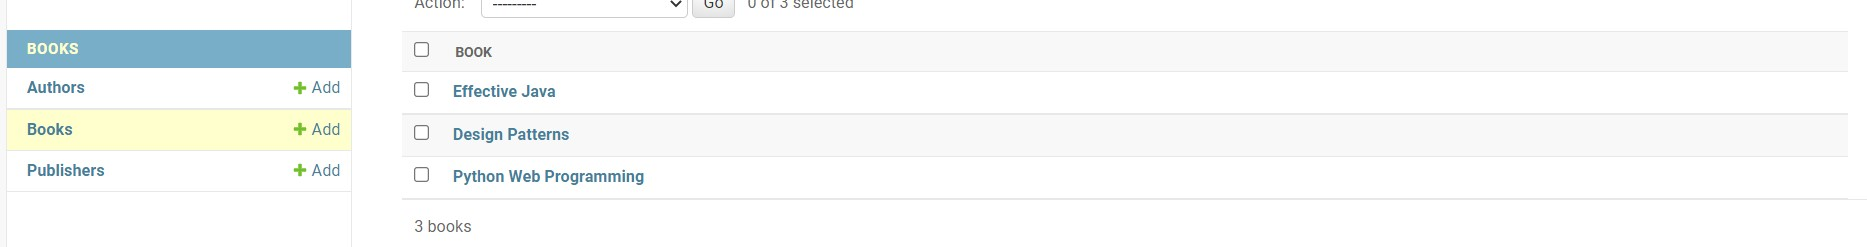
**추가된 BOOK 테이블의 데이터**

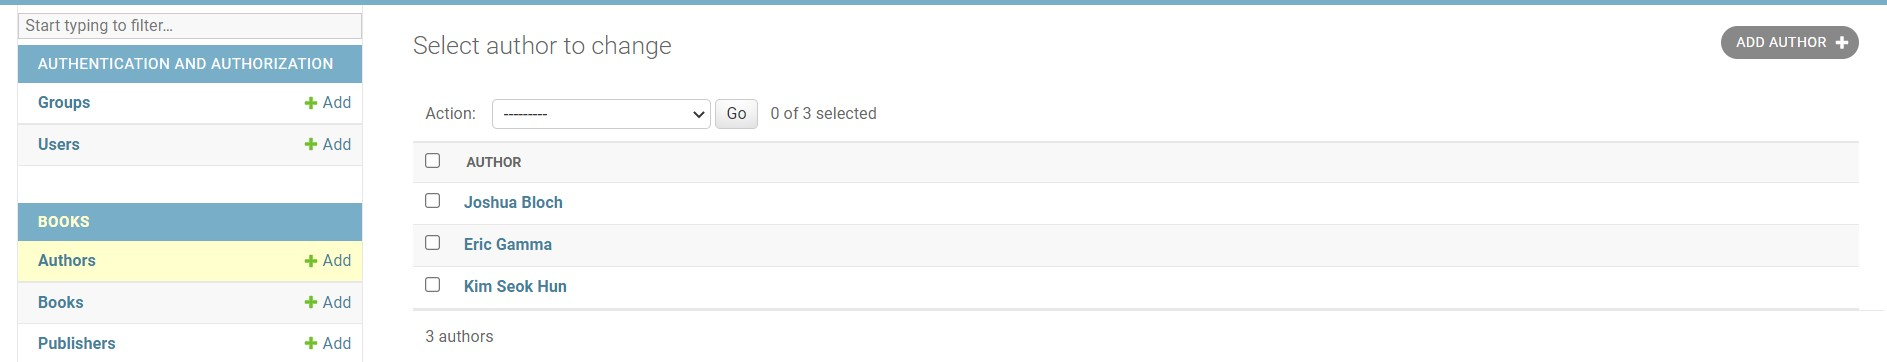
**추가된 AUTHOR 테이블의 데이터**

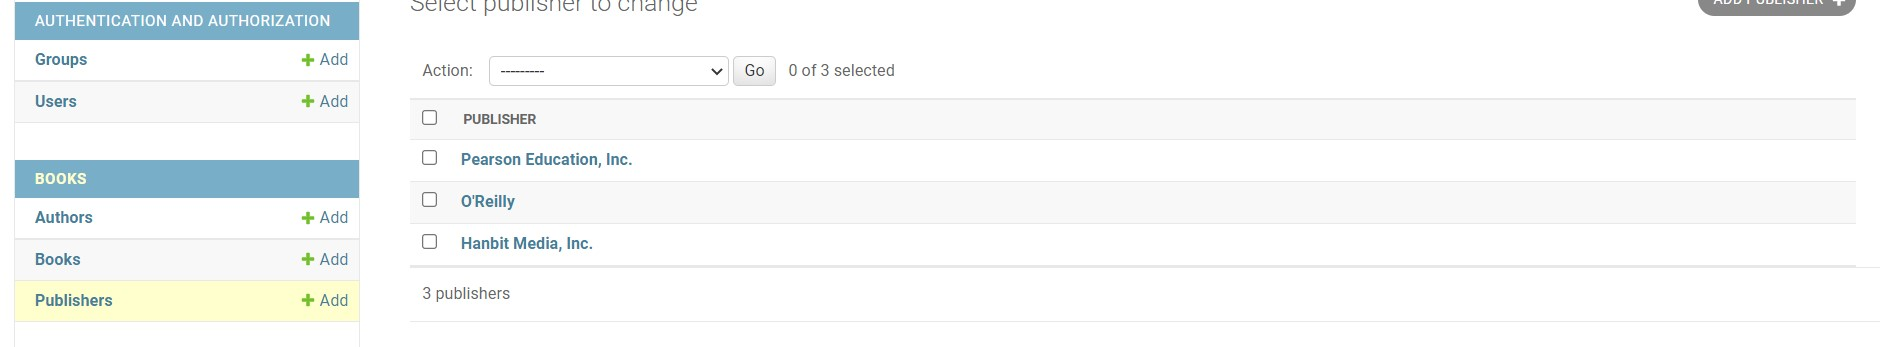
**추가된 PUBLISHER 테이블의 데이터**

## 8) HOME 페이지 설계

: 프로젝트 관련이므로 mysite의 파일 이용

**1. url의 추가**
```
mysite/urls.py

from django.contrib import admin
# include 추가
from django.urls import path, include
from mysite import views

urlpatterns = [
    path('admin/', admin.site.urls),
    path('polls/', include('polls.urls')),
    path('books/', include('books.urls')),
    path('', views.HomeView.as_view(), name = 'home'),
]
```

**2. view 코딩하기**
```
mysite/views.py

from django.views.generic.base import TemplateView

# TemplateView

class HomeView(TemplateView) :
    # 필수 지정
    template_name = 'home.html'

    # 추가 컨텍스트 변수
    def get_context_data(self, **kwargs) :
        context = super().get_context_data(**kwargs)
        context['app_list'] = ['polls', 'books']
        return context
```

**3. 템플릿 코딩하기**
```
templates

<!-- 상속 이용 -->
{% extends "base.html" %}

{% block content %}
    <h2>gmHwang Django Applications </h2>
    <ul>
        {% for appname in app_list %}
{% with appname|add":"|add:"index" as urlvar %}
            <li><a href = "{% url urlvar %}">{{ appname }}</a></li>
{% endwith %}
        {% endfor %}
    </ul>
{% endblock content %}
```

## 9) APPS 활용하기

**1. apps 추가**
```
books/apps.py

from django.apps import AppConfig


class BooksConfig(AppConfig):
    default_auto_field = 'django.db.models.BigAutoField'
    name = 'books'
    # 추가
    verbose_name = 'Book-Author-Publisher App'
```

**2. 함수 수정**
```
mysite/views.py

from django.views.generic.base import TemplateView
from django.apps import apps

# TemplateView

class HomeView(TemplateView) :
    # 필수 지정
    template_name = 'home.html'

    # 추가 컨텍스트 변수
    def get_context_data(self, **kwargs) :
        context = super().get_context_data(**kwargs)
        # context['app_list'] = ['polls', 'books']
        dictVerbose = {}
        # 각 앱의 설정 클래스 조회
        for app in apps.get_app_configs() :
            # 외부 라이브러리는 조회 안함
            if 'site-packages' not in app.path :
                # {label : verbose_name} ({books : Book-Author-Publisher})
                dictVerbose[app.label] = app.verbose_name
        context['verbose_dict'] = dictVerbose
        return context
```

**3. 템플릿 수정**
```
templates/home.html

<!-- 상속 이용 -->
{% extends "base.html" %}

{% block content %}
    <h2>gmHwang Django Applications </h2>
    <ul>
        <!-- {% for appname in app_list %}
{% with appname|add:":"|add:"index" as urlvar %}
            <li><a href = "{% url urlvar %}">{{ appname }}</a></li>
{% endwith %}
        {% endfor %} -->
    
        {% for key, value in verbose_dict.items %}
            <li><a href = "{% url key|add:':index' %}">{{ value }}</a></li>
        {% endfor %}
    </ul>
{% endblock content %}
```

**4. 설정 변경**
```
mysite/settings.py

INSTALLED_APPS = [
    'django.contrib.admin',
    'django.contrib.auth',
    'django.contrib.contenttypes',
    'django.contrib.sessions',
    'django.contrib.messages',
    'django.contrib.staticfiles',
    # 추가된 설정
    'polls.apps.PollsConfig',
    # 'books.apps.BooksConfig',
    'books',
]
```

## 10) POLLS 애플리케이션 수정

: 기존 하드코딩 View를 클래스형 View로 변경하기

**1. URLconf 변경**
```
polls/urls.py

from django.urls import path
from polls import views

app_name = 'polls'

urlpatterns = [
    path('', views.IndexView.as_view(), name = 'index'),
    path('<int:pk>/', views.DetailView.as_view(), name = 'detail'),
    path('<int:pk>/results/', views.ResultsView.as_view, name = 'results'),
    path('<int:question_id>/vote/', views.vote, name = 'vote'),
]
```

**2. View 변경**
```
polls/views.py

# table에 접근
from polls.models import Choice, Question
# 클래스형 뷰
from django.views import generic

class IndexView(generic.ListView) :
    template_name = 'polls/index.html'
    context_object_name = 'latest_question_list'

    def get_queryset(self) :
        return Question.objects.order_by('-pub_date')[:5]

class DetailView(generic.DetailView) :
    model = Question
    template_name = 'polls/detail.html'

# view 함수 만들기
def vote(request, question_id) :
    question = get_object_or_404(Question, pk = question_id)
    try :
        # POST로 전달 받은 choice_id value
        selected_choice = question.choice_set.get(pk = request.POST['choice'])
    except (KeyError, Choice.DoesNotExist) :
        # 설문 투표 폼을 다시 보여줌
        return render(request, 'polls/detail.html', {
            'question' : question,
            'error_message' : "You didn't select a choice.",
        })
    else :
        # 선택된 투표사항에 +1
        selected_choice.votes += 1
        # Choice 테이블에 저장
        selected_choice.save()
        # POST 데이터 정상 처리시, 항상 HTTPRESONSEREDIRECT를 반환하여 리다이렉션
        return HttpResponseRedirect(reverse('polls:results', args = (question.id,)))

class ResultView(generic.DetailView) :
    model = Question
    template_name = 'polls/results.html'
```

**3. 템플릿 수정**
```
1. base.html

templates/base_polls.html

{% extends base.html %}

<title> {% block title %} Polls Application Site {% endblock title %} </title>

{% block sidebar %}
{{ block.super }}
<ul>
    <li><a href = "/polls/"> Polls_Home </a></li>
</ul>
{% endblock sidebar %}

2. index.html

templates/polls/index.html

{% entends base_polls.html %}

{% block content %}
<h2> Polls Quesiton List </h2>

{% if latest_question_list %}
    <ul>
        {% for question in latest_question_list %}
            <li><a href = "{% url 'polls:detail' question.id %}"> {{ question.question_text }} </a></li>
        {% endfor %}
        </ul>
{% else %}
        <p> No Polls are available.</p>
{% endif %}

{% endblock content %}

3. detail.html

templates/polls/detail.html

{% extends base_polls.html %}

{% block content %}

<h1>{{ question.question_text }}</h1>

{% if error_message %}<p><strong>{{ error_message }}</strong></p>{% endif %}

<!-- polls:vote에 선택된 질문 POST 방식으로 보내기-->
<form action = "{% url 'polls:vote' question.id %}" method = "post">
<!-- csrf 공격 보안-->
{% csrf_token %}
<!-- Question 테이블에 있는 choice 항목 모두 보여주기-->
{% for choice in question.choice_set.all %}
    <!-- radio 버튼으로 폼 구성-->
    <input type = "radio" name = "choice" id = "choice{{ forloop.counter }}" value = "{{ choice.id }}"   />
    <!-- label for과 input id는 같아야 됨-->
    <label for = "choice{{ forloop.counter }}">{{ choice.choice_text }}</label><br />
{% endfor %}
<!-- vote 버튼 클릭 시 POST 방식으로 polls:vote에 전송-->
<input type = "submit" value = "Vote" />
</form>

{% endblock content %}

4. result.html

{% extends "base_polls.html" %}

{% block content %}

<h1>{{ question.question_text }}</h1>

<ul>
{% for choice in question.choice_set.all %}
    <!-- choice의 객체를 순서 없는 리스트로 반환, vote의 값에 따른 votes/vote 결정-->
    <li>{{ choice.choice_text }} - {{ choice.votes }} vote{{ choice.votes|pluralize }}</li>
{% endfor %}
</ul>

<a href = "{% url 'polls:detail' question.id %}"> Vote again?</a>

{% endblock content %}
```

**4. 로그 추가하기 **

```
1. 설정 변경
mysite/settings.py

STATIC_URL = 'static/'

LOGGING = {
    'version' : 1,
    'disable_existing_loggers' : False,
    'formatters' : {
        'verbose' : {
            'format' : "[%(asctime)s] %(levelname)s [%(name)s:%(lineno)s] %(messages)s",
            'datefmt' : "%d/%b/%Y %H:%M:%S"
        },
    },

    'handlers' : {
        'file' : {
            'level' : 'DEBUG',
            'class' : 'logging.FileHandler',
            'filename' : os.path.join(BASE_DIR, 'logs', 'mysite.log'),
            'formatters' : 'verbose'
        },
    }
    'loggers' : {
        'polls' : {
            'handlers' : ['file'],
            'level' : 'DEBUG',
        },
    },
}

2. view 추가

polls/views.py

import logging
logger = logging.getLogger(__name__)

logger.debug("vote().question_id : %s" % question_id)
